In [20]:
import ot
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.morphology import disk
from skimage.measure import regionprops_table
from scipy.spatial.distance import cdist
from tifffile import imread, imwrite
from sklearn.decomposition import PCA

In [2]:
def OT(target, reference):
    a = target.flatten()
    b = reference.flatten()
    costMatrix = cdist(a.reshape(-1,1), b.reshape(-1,1))
    transportMap = ot.emd(a, b, costMatrix)
    appliedMap = transportMap@costMatrix
    embedding = np.concatenate([np.sum(appliedMap,axis=0),np.sum(appliedMap,axis=1)])
    return embedding

In [21]:
dataPath = '/project/zunderlab/heussner/Projects/morph/data/CODEX_LN/'
savePath = '/project/zunderlab/heussner/Projects/morph/results/'
marker = 'CD68'
tilePath = os.path.join(dataPath,f'CODEX_LN_tiles/{marker}.pkl')
with open(tilePath,'rb') as handle:
    tiles = pickle.load(handle)

In [16]:
reference = np.pad(disk(6),((10,9),(9,10)))
reference = reference / np.sum(reference).astype(int)

In [25]:
tileSize = 32
embeddings = np.zeros((len(tiles),(tileSize**2)*2))
for i,t in enumerate(tiles.values()):
    embeddings[i,:] = OT(t, reference)

In [26]:
with open(os.path.join(savePath, 'OT_embeddings.pkl'),'wb') as handle:
    pickle.dump(embeddings, handle)

In [30]:
model = PCA()
pca = model.fit(embeddings)

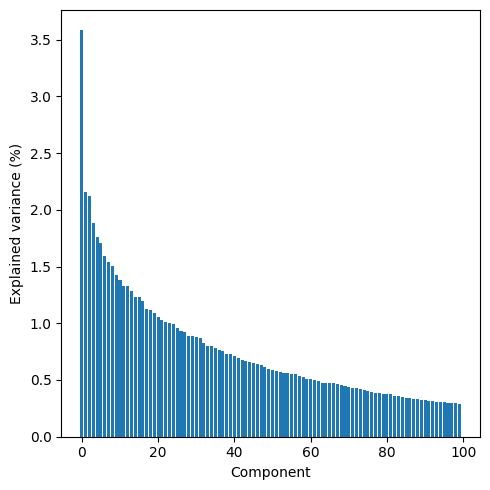

In [45]:
plt.figure(figsize=(5,5))
plt.bar([i for i in range(100)], pca.explained_variance_ratio_[0:100]*100)
plt.xlabel('Component')
plt.ylabel('Explained variance (%)')
plt.tight_layout()
plt.savefig(os.path.join(savePath,'OT_ExplainedVariance.png'),dpi=500,bbox_inches='tight')
plt.show()

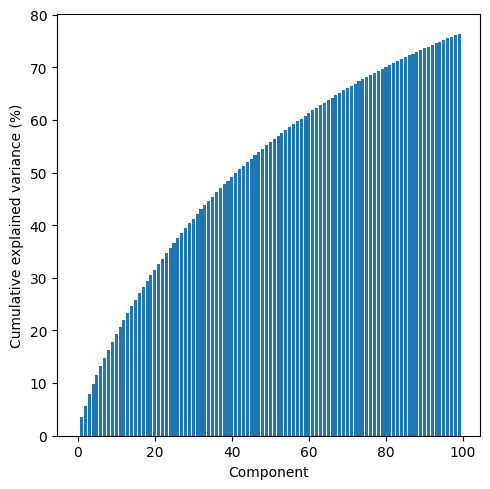

In [46]:
plt.figure(figsize=(5,5))
plt.bar([i for i in range(100)], [np.sum(pca.explained_variance_ratio_[0:i]*100) for i in range(100)])
plt.xlabel('Component')
plt.ylabel('Cumulative explained variance (%)')
plt.tight_layout()
plt.savefig(os.path.join(savePath,'OT_cumExplainedVariance.png'),dpi=500,bbox_inches='tight')
plt.show()

In [49]:
# do these features correlate with mean intensity?
table = pd.read_csv(os.path.join(dataPath,'CODEX_LN_table.csv'))

In [50]:
labelOrder = [] # need order of cells to match X's and Y's
X = []
meanIntensities = []
for label, tile in tiles.items():
    labelOrder.append(label)
    meanIntensities.append(np.mean(tile[tile>0]))
    X.append(tile)

X = np.array(X)
meanIntensities = np.array(meanIntensities)
labelOrder = np.array(labelOrder)
  
table_ = table[table['label'].isin(list(labelOrder))].copy() # filter out unsampled cells
table_ = table_.sort_values(by="label", key=lambda column: column.map(lambda e: list(labelOrder).index(e))) # sort table rows to be in same order as cell tiles

In [57]:
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr

In [52]:
Y = table_[marker].to_numpy() # select marker mean intensity
Y = np.log(1+Y)

In [56]:
result = CCA(n_components=1).fit_transform(embeddings, Y)

In [63]:
pearsonr(Y, result[0])

PearsonRResult(statistic=array([0.40695349111895374], dtype=object), pvalue=0.0)

In [62]:
result[1].shape

(107261, 1)